In [49]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
import anndata as ad
#pip install opencv-python and opencv-python-headless
import cv2

In [50]:
spg.__version__

'1.2.5'

In [51]:
#Read in gene expression and spatial location
import scanpy as sc
adata = sc.read_h5ad("/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior.h5ad")
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [52]:
#Select captured samples
adata.var_names=[i.upper() for i in list(adata.var_names)]#将字符串的小写字母变成大写字母
adata.var["genename"]=adata.var.index.astype("str")
adata.obs['x_pixel']=adata.obs['array_row']
adata.obs['y_pixel']=adata.obs['array_col']

x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()
adata


AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'x_pixel', 'y_pixel'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial'
    obsm: 'spatial'

In [53]:
#Calculate adjacent matrix
#每一个端点代表一个测序捕获区域（spot）， 而连接两个端点的加权边则代表了两个测序捕获区域在空间和形态特征上的接近程度
s=1#s表示在计算每两个点之间的欧几里得距离时赋予组织学的权重，s=1意味着组织学像素强度值与 (x,y) 坐标具有相同的尺度方差，s越大意味着尺度越大。
b=49#b表示当提取颜色强度时每个spot的面积
# adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('./adj.csv', adj, delimiter=',')#3639*3639的邻接矩阵

Calculateing adj matrix using xy only...


In [54]:
#spatial domain detection using SpaGCN

#expression data preprocessing
adj=np.loadtxt('./adj.csv', delimiter=',')
adata.var_names=adata.var.index.astype("str")
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [55]:
#set hyper-parameters
#p:对邻域贡献的总表达百分比，l:控制p的参数
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 3348.9362454045777]
Run 2: l [0.01, 500.005], p [0.0, 3333.836713431602]
Run 3: l [0.01, 250.0075], p [0.0, 3274.7818029101586]
Run 4: l [0.01, 125.00874999999999], p [0.0, 3058.310073660788]
Run 5: l [0.01, 62.509375], p [0.0, 2424.8499505292143]
Run 6: l [0.01, 31.2596875], p [0.0, 1367.153117638053]
Run 7: l [0.01, 15.63484375], p [0.0, 529.1320988381385]
Run 8: l [0.01, 7.822421875], p [0.0, 160.3107972880128]
Run 9: l [0.01, 3.9162109375], p [0.0, 43.21012013828191]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 10.596451800300086]
Run 11: l [0.01, 0.9865527343749999], p [0.0, 1.996322296076246]
Run 12: l [0.49827636718749996, 0.9865527343749999], p [0.07051341494360597, 1.996322296076246]
Run 13: l [0.49827636718749996, 0.74241455078125], p [0.07051341494360597, 0.7401019910786686]
Run 14: l [0.620345458984375, 0.74241455078125], p [0.3108291991259857, 0.7401019910786686]
recommended l =  0.6813800048828125


In [56]:
#n_clusters:想要的空间domain的数量；res：初始 Louvain 聚类方法中的分辨率。如果已知cluster的数量，我们可以使用 spg.search_res() 函数来搜索合适的分辨率（可选）

#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
resolution_list=[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5]

In [57]:
for i in range(10):
    adata_copy=adata.copy()
    adj_copy=adj.copy()
    #run SpaGCN
    clf=spg.SpaGCN()
    clf.set_l(l)
    #Set seed
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    #Run
    clf.train(adata_copy,adj_copy,init_spa=True,init="louvain",res=resolution_list[i], tol=5e-3, lr=0.05, max_epochs=200)
    y_pred, prob=clf.predict()
    adata.obs["pred_{}".format(i+1)]= y_pred
    adata.obs["pred_{}".format(i+1)]=adata.obs["pred_{}".format(i+1)].astype('category')
    

    #Do cluster refinement(optional)
    #shape="hexagon" for Visium data, "square" for ST data.
    adj_2d=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
    refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred_{}".format(i+1)].tolist(), dis=adj_2d, shape="hexagon")
    adata.obs["refined_pred_{}".format(i+1)]=refined_pred
    adata.obs["refined_pred_{}".format(i+1)]=adata.obs["refined_pred_{}".format(i+1)].astype('category')

adata.write('./V1_Mouse_Brain_Sagittal_Posterior(resolution).h5ad')
adata


Initializing cluster centers with louvain, resolution =  0.1
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0035767511177347243 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 31
Calculateing adj matrix using xy only...
Initializing cluster centers with louvain, resolution =  0.5
Epoch  0
Epoch  10
Epoch  20
delta_label  0.0035767511177347243 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 25
Calculateing adj matrix using xy only...
Initializing cluster centers with louvain, resolution =  1
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0035767511177347243 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 31
Calculateing adj matrix using xy only...
Initializing cluster centers with louvain, resolution =  1.5
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.002384500745156483 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 37
Calculateing adj matrix using xy only...
Initializ

AnnData object with n_obs × n_vars = 3355 × 19125
    obs: 'in_tissue', 'array_row', 'array_col', 'x_pixel', 'y_pixel', 'n_counts', 'pred_1', 'refined_pred_1', 'pred_2', 'refined_pred_2', 'pred_3', 'refined_pred_3', 'pred_4', 'refined_pred_4', 'pred_5', 'refined_pred_5', 'pred_6', 'refined_pred_6', 'pred_7', 'refined_pred_7', 'pred_8', 'refined_pred_8', 'pred_9', 'refined_pred_9', 'pred_10', 'refined_pred_10'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [58]:
# from sklearn import metrics
# ari = metrics.adjusted_rand_score(adata.obs['gt'], adata.obs['pred'])
# ari

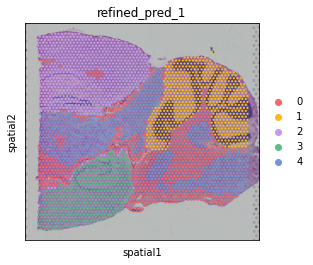

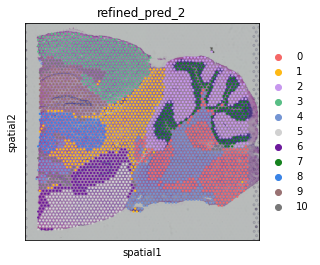

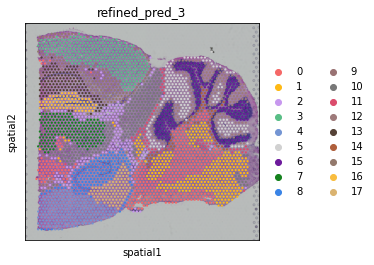

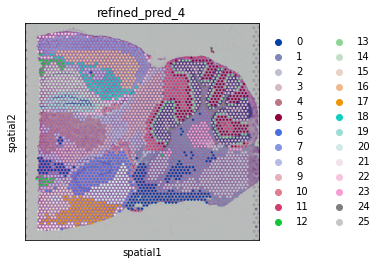

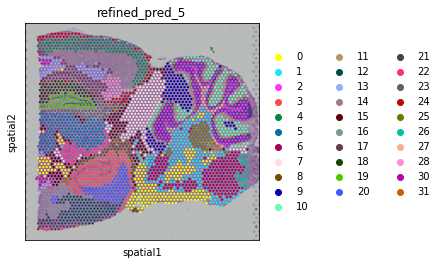

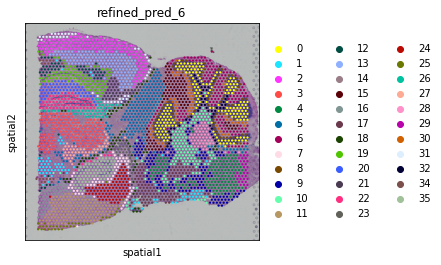

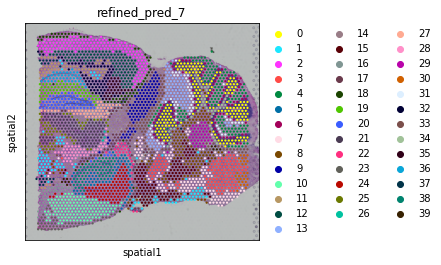

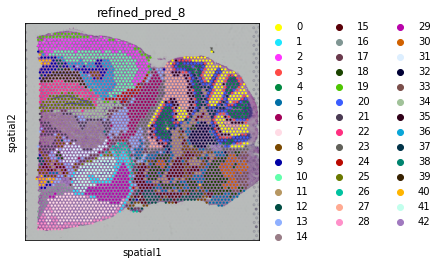

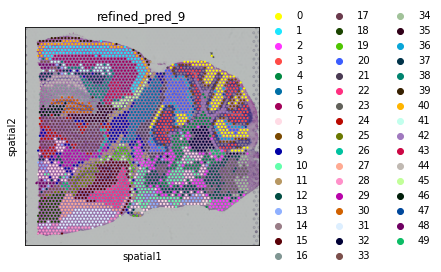

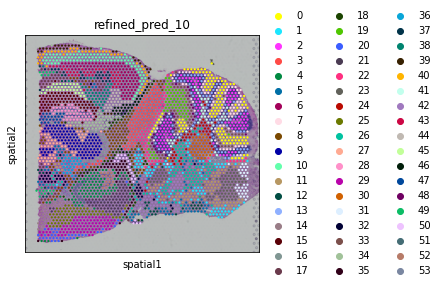

In [65]:
#Plot spatial domains

#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
for i in range(10):
    adata=sc.read("./V1_Mouse_Brain_Sagittal_Posterior_Section_2(resolution).h5ad")
    domains="pred_{}".format(i+1)
    num_celltype=len(adata.obs[domains].unique())
    adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
    sc.pl.spatial(adata, img_key="hires", color=[domains], show=False)
    # ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,show=False,size=100000/adata.shape[0])#color_map=plot_color,
    # ax.set_aspect('equal', 'box')
    # ax.axes.invert_yaxis()
    plt.savefig("./result_png/pred_{}.png".format(i+1), dpi=600)
    plt.close()

    #Plot refined spatial domains
    domains_refined="refined_pred_{}".format(i+1)
    num_celltype=len(adata.obs[domains].unique())
    adata.uns[domains_refined+"_colors"]=list(plot_color[:num_celltype])
    sc.pl.spatial(adata, img_key="hires", color=[domains_refined], show=False)
    plt.savefig("./result_png/refined_pred_{}.png".format(i+1), dpi=600)